In [1]:
import seaborn as sns
import torch
import torch.nn.functional as F
import numpy as np
from argparse import Namespace
from pyscf import gto, scf, dft
from pyscf.grad import rhf
from ase.io import read
from ase.units import Bohr
import math
import sqlite3 as sql
import matplotlib.pyplot as plt
import os
import pandas as pd
dtype = torch.float32
T = lambda x: torch.tensor(x, dtype=dtype)

read_binaries32 = lambda x: torch.frombuffer(x, dtype=torch.float32).numpy()

dtype = np.float32
btrace = lambda X: np.einsum("bii->b", X)



In [2]:
"""
#######################################################################
################ PSD ERROR FUNCTIONS AND H2O MOLECULES ################
#######################################################################
"""

"""
#######################################################################
################ FROM ORCA TO PYSCF CONVENTIONS ################
######################################################################
"""



convention_dict = {
   'pyscf': Namespace(
    atom_to_orbitals_map={'H':'ssp','O':'sssppd','C':'sssppd','N':'sssppd'},
    orbital_idx_map={'s':[0], 'p':[1,2,0], 'd':[4,2,0,1,3]},
    orbital_sign_map={'s':[1], 'p':[1,1,1], 'd':[1,1,1,1,1]},
    orbital_order_map={'H':[0,1,2],'O':[0,1,2,3,4,5],'C':[0,1,2,3,4,5],'N':[0,1,2,3,4,5]},
),
    
    'orca': Namespace(
        atom_to_orbitals_map={'H': 'ssp', 'O': 'sssppd', 'C': 'sssppd', 'N': 'sssppd'},
        orbital_idx_map={'s': [0], 'p': [2, 0, 1], 'd': [4, 2, 0, 1, 3]},
        orbital_sign_map={'s': [1], 'p': [1, 1, 1], 'd': [1, 1, 1, 1, 1]},
        orbital_order_map={'H': [0, 1, 2], 'O': [0, 1, 2, 3, 4, 5], 'C': [0, 1, 2, 3, 4, 5], 'N': [0, 1, 2, 3, 4, 5]},
    ),


     'pysch': Namespace(
        atom_to_orbitals_map={'H': 'ssp', 'O': 'sssppd', 'C': 'sssppd', 'N': 'sssppd'},
        orbital_idx_map={'s': [0], 'p': [2, 0, 1], 'd': [2, 3, 1, 4, 0]},
        orbital_sign_map={'s': [1], 'p': [1, 1, 1], 'd': [1, 1, 1, 1, 1]},
        orbital_order_map={'H': [0, 1, 2], 'O': [0, 1, 2, 3, 4, 5], 'C': [0, 1, 2, 3, 4, 5], 'N': [0, 1, 2, 3, 4, 5]},
    ),

     'pyphi': Namespace(
        atom_to_orbitals_map={'H': 'ssp', 'O': 'sssppd', 'C': 'sssppd', 'N': 'sssppd'},
        orbital_idx_map={'s': [0], 'p': [1, 2, 0], 'd': [0, 1, 2, 3, 4]},
        orbital_sign_map={'s': [1], 'p': [1, 1, 1], 'd': [1, 1, 1, 1, 1]},
        orbital_order_map={'H': [0, 1, 2], 'O': [0, 1, 2, 3, 4, 5], 'C': [0, 1, 2, 3, 4, 5], 'N': [0, 1, 2, 3, 4, 5]},
    ),

     'phipy': Namespace(
        atom_to_orbitals_map={'H': 'ssp', 'O': 'sssppd', 'C': 'sssppd', 'N': 'sssppd'},
        orbital_idx_map={'s': [0], 'p': [2, 0, 1], 'd': [0, 1, 2, 3, 4]},
        orbital_sign_map={'s': [1], 'p': [1, 1, 1], 'd': [1, 1, 1, 1, 1]},
        orbital_order_map={'H': [0, 1, 2], 'O': [0, 1, 2, 3, 4, 5], 'C': [0, 1, 2, 3, 4, 5], 'N': [0, 1, 2, 3, 4, 5]},
    ),



}

def transform(hamiltonians,convention, atoms = "OHH"):
    conv = convention_dict[convention]
    #print('atoms', atoms)
    orbitals = ''
    orbitals_order = []
    for a in atoms:
        offset = len(orbitals_order)
        #print('svr aroms to orbs', conv.atom_to_orbitals_map[a])
        orbitals += conv.atom_to_orbitals_map[a]
        orbitals_order += [idx + offset for idx in conv.orbital_order_map[a]]

    #print('orbitals', orbitals)
    #print('orbitals order', orbitals_order)

    transform_indices = []
    transform_signs = []
    for orb in orbitals:
        offset = sum(map(len, transform_indices))
        map_idx = conv.orbital_idx_map[orb]
        map_sign = conv.orbital_sign_map[orb]
        transform_indices.append(np.array(map_idx) + offset)
        transform_signs.append(np.array(map_sign))

    transform_indices = [transform_indices[idx] for idx in orbitals_order]
    transform_signs = [transform_signs[idx] for idx in orbitals_order]
    #print('transform_indices', transform_indices)
    transform_indices = np.concatenate(transform_indices).astype(int)
    transform_signs = np.concatenate(transform_signs)


    hamiltonians_new = hamiltonians[...,transform_indices, :]
    hamiltonians_new = hamiltonians_new[...,:, transform_indices]
    hamiltonians_new = hamiltonians_new * transform_signs[:, None]
    hamiltonians_new = hamiltonians_new * transform_signs[None, :]

    return hamiltonians_new
    
def create_pyscf_molecule(coordinates: np.ndarray, chemical_symbols: list = ["O", "H", "H"], basis_set: str = 'def2-SVP'):
    """
    Creates a PySCF Molecule object from given atomic coordinates and symbols.

    Args:
        coordinates (np.ndarray): A NumPy array of shape (N, 3) where N is the number of atoms,
                                  containing the Cartesian coordinates (x, y, z) for each atom.
                                  Units are assumed to be Angstroms (PySCF default for input).
        chemical_symbols (list): A list of strings representing the chemical symbol for each atom,
                                 in the same order as the rows in 'coordinates'.
        basis_set (str): The name of the Gaussian basis set to use (e.g., 'sto-3g', 'cc-pVDZ').
                         Defaults to 'cc-pVDZ' as requested.

    Returns:
        pyscf.gto.mole.Mole: A PySCF Molecule object.

    Raises:
        ValueError: If the number of chemical symbols does not match the number of atom coordinates.
    """
    # Verify the number of symbols matches the number of atoms in coordinates
    if len(chemical_symbols) != coordinates.shape[0]:
        raise ValueError("Number of chemical symbols must match the number of atom coordinates.")

    # Prepare the 'atom' argument for gto.M()
    # This requires a list of [atom_symbol, [x, y, z]] for each atom.
    atom_data = []
    for i in range(len(chemical_symbols)):
        atom_data.append([chemical_symbols[i], coordinates[i].tolist()])

    # Create the PySCF Molecule object
    mol = gto.M(
        atom=atom_data,
        basis=basis_set,
        unit = "Bohr",
        verbose=0 # Set to 0 to suppress detailed output during molecule creation
    )
    mol.build()
    return mol


In [3]:
conn = sql.connect("h2o_pbe-def2svp_4999.db")
cursor = conn.cursor()
dmsb = cursor.execute("SELECT P FROM data").fetchall()
ssb = cursor.execute("SELECT S FROM data").fetchall()
dms = np.array([read_binaries32(dm[0]).reshape(24,-1) for dm in dmsb ])
ss = np.array([read_binaries32(dm[0]).reshape(24,-1) for dm in ssb ])
conn.close()
conn = sql.connect("fresh_bohr_h2o_pbe-def2svp_4999.db")
cursor = conn.cursor()
fsb = cursor.execute("SELECT H FROM data").fetchall()
fs = np.array([read_binaries32(dm[0]).reshape(24,-1) for dm in fsb ])
conn.close()

/var/folders/8d/k0f53h611hn08ljltzmmh8br0000gn/T/ipykernel_20886/458515391.py:18: UserWarning: The given buffer is not writable, and PyTorch does not support non-writable tensors. This means you can write to the underlying (supposedly non-writable) buffer using the tensor. You may want to copy the buffer to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /private/var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_951ooclnw1/croot/libtorch_1746637517770/work/torch/csrc/utils/tensor_new.cpp:1566.)
  read_binaries32 = lambda x: torch.frombuffer(x, dtype=torch.float32).numpy()


In [4]:
######-------PERSONALIZE PATHS------------######
dir_path = "2025-08-12_rg0GBIT1"
datasplit_path = os.path.join(dir_path, "datasplits.npz")
N = 10.0
######-------FIXED PATHS------------######
path_key = dir_path.split("_")[-1]
preds_path = os.path.join(dir_path, "useful_data"+path_key+".npy")

datasplit_path = os.path.join(dir_path, "datasplits.npz")
datasplit = np.load(datasplit_path, allow_pickle=True)
valid_indices = [i for i in datasplit["valid"]]
eval_preds= np.load(preds_path, allow_pickle=True).item()["predicted"]["eval"]
eval_preds = np.array([e for e in eval_preds]).transpose(1,0,2,-1)
dms_pred = np.array([dm[0] for dm in eval_preds])
#dms_pred = dms_pred @ dms_pred.transpose(0,-1, -2) / np.linalg.norm(dms_pred, axis = (-2, -1))[:, None, None]**2
ss_pred =  np.array([dm[1] for dm in eval_preds])
dms_real = np.array([dms[i] for i in valid_indices])
ss_real = np.array([ss[i] for i in valid_indices])
fs1 = np.array([fs[i] for i in valid_indices]) 
fs_real = np.array([fs[i] for i in valid_indices])
ss_diff = np.abs(ss_real-ss_pred)
dm_diff = np.abs(dms_real-dms_pred)
dm_eigvals_pred = np.linalg.eigvalsh(dms_pred)
s_eigvals_pred = np.linalg.eigvalsh(ss_pred)
dm_eigvals_real = np.linalg.eigvalsh(dms_real)
s_eigvals_real = np.linalg.eigvalsh(ss_real)
tr_err = np.abs(np.einsum("bii->b", np.einsum("bij,bjk->bik", dms_pred, ss_real )) - N)
id_err = np.abs(dms_pred@ss_real@dms_pred - 2*dms_pred)
symme = np.abs(dms_pred- dms_pred.transpose(0, -1, -2))
np.mean(np.abs(dm_eigvals_real-dm_eigvals_pred))

bulk_data = torch.load("num_bulk_data.pth", weights_only = False)
rs = np.array([bulk_data[i]["positions"].view(3,-1) for i in valid_indices])
dP = dms_pred - dms_real               # so positive means energy↑
dE = np.einsum('bij,bij->b', dP, fs_real).astype(np.float64)
abs_dE = np.abs(dE)
np.mean(abs_dE)
np.mean(dm_diff)


np.float32(1.0068551e-05)

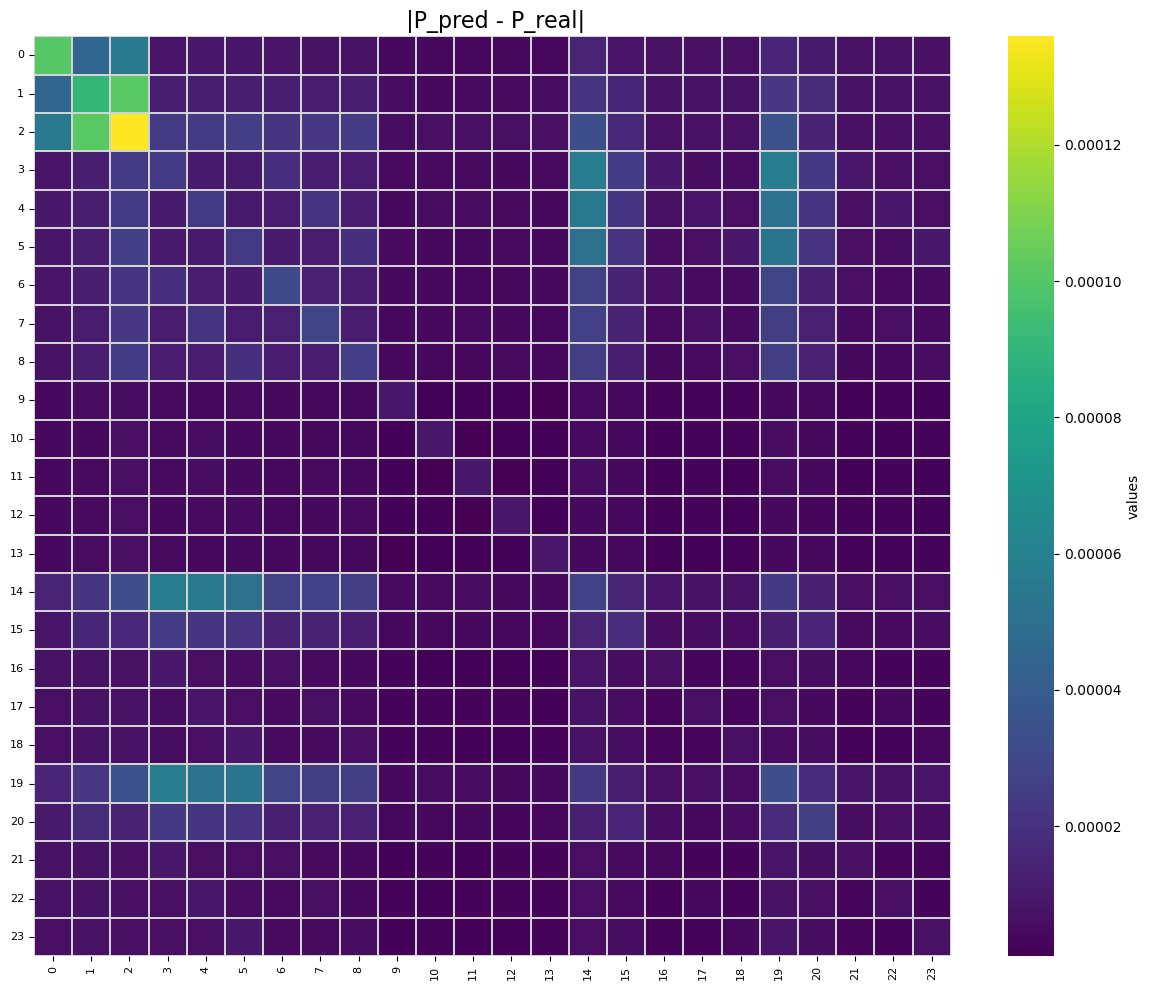

In [5]:
"""
######################################################################
################ HEATMAPS #############################################
######################################################################
"""

data = np.mean(dm_diff, 0)

# Basis functions for Nitrogen (N) in cc-pVDZ (14 functions)
# Standard nomenclature typically includes principal quantum numbers where relevant.
o_bfs = [
    'O 1s', 'O 2s', 'O 3s',                 # 3 s-type functions
    'O 2px', 'O 2py', 'O 2pz',              # 1st set of p-type functions (2p)
    'O 3px', 'O 3py', 'O 3pz',              # 2nd set of p-type functions (3p - polarization)
    'O 1dxy', 'O 1dxz', 'O 1dyz', 'O 1dx2-y2', 'O 1dz2' # 1 set of d-type functions (1d - polarization)
]

# Basis functions for Hydrogen (H) in cc-pVDZ (5 functions)
# H is 2s, 1p
h_bfs_template = [ # Using a template for H to easily differentiate H1 and H2
    '1s', '2s',
    '1px', '1py', '1pz'
]

# Construct combined labels for H2O in O, H1, H2 order
all_labels_h2o = o_bfs + \
                 [f'H1 {bf}' for bf in h_bfs_template] + \
                 [f'H2 {bf}' for bf in h_bfs_template]
# --- Create the Heatmap using Seaborn ---

# Set a larger figure size for better visibility
plt.figure(figsize=(12, 10)) # Increased size for 29x29 matrix and labels

sns.heatmap(data,
            annot=False,      # Set to True to show values (might be too crowded for 29x29)
            cmap='viridis',   # Color map (e.g., 'viridis', 'plasma', 'coolwarm', 'RdBu')
            linewidths=.2,    # Lines between cells for separation
            linecolor='lightgray', # Color of the lines
            cbar=True,        # Show color bar
            cbar_kws={'label': 'values'} # Specific label for the color bar
           )

# Add titles and labels for clarity
plt.title(' |P_pred - P_real|', fontsize=16)
# Labels are handled by the DataFrame index/columns by default.
# If you want to explicitly add general labels for axes:
# plt.xlabel('Basis Function Index', fontsize=12)
# plt.ylabel('Basis Function Index', fontsize=12)

# Rotate x-axis labels for better readability if they overlap
plt.xticks(rotation=90, fontsize=8) # Rotate by 90 degrees for vertical labels
plt.yticks(rotation=0, fontsize=8)  # Keep y-axis labels horizontal

# Ensure the layout is tight to prevent labels from overlapping
plt.tight_layout()


# --- NEW LINE TO SAVE THE PLOT ---
plt.savefig('dm_diff_hm.png', dpi=300, bbox_inches='tight')
# Display the plot
plt.show()

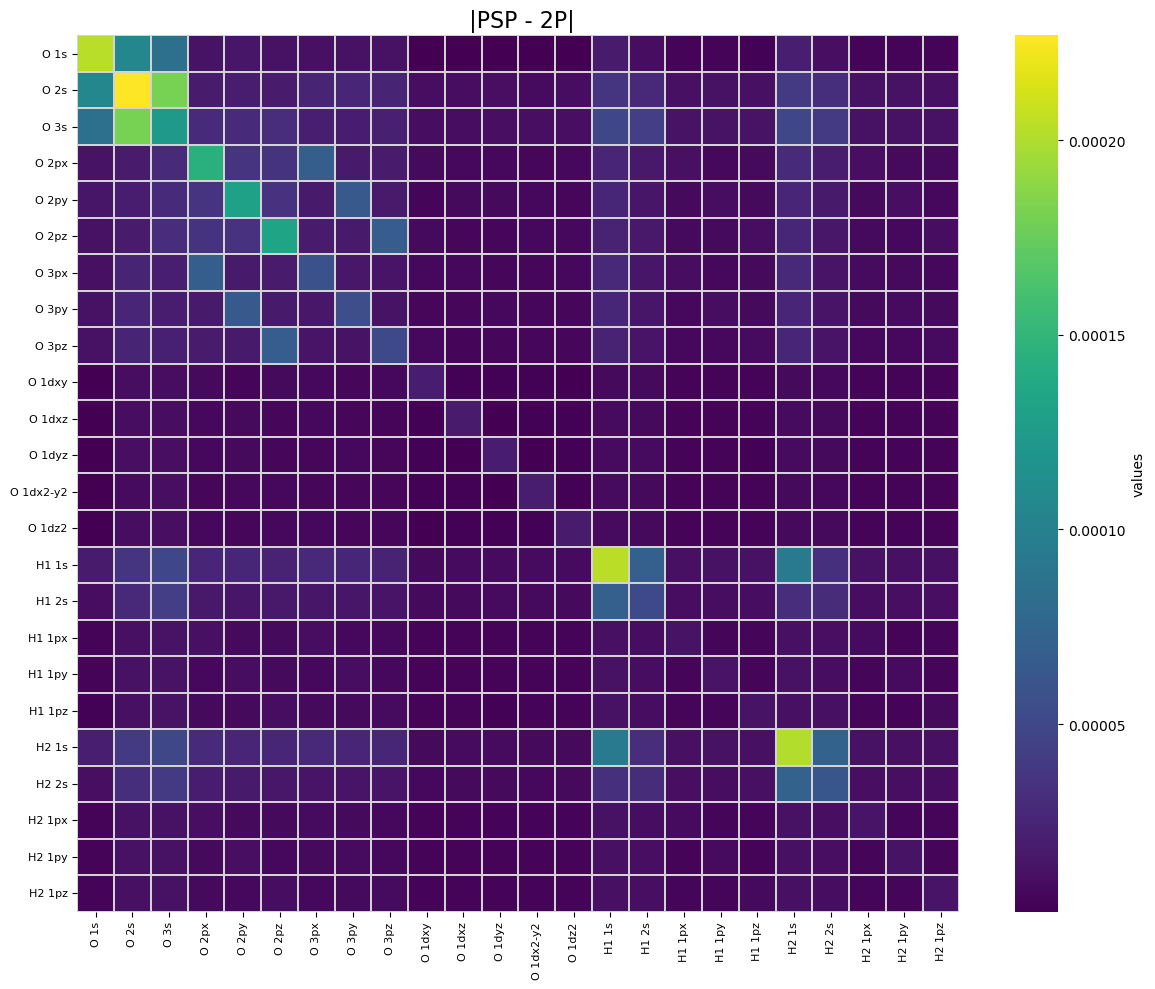

In [6]:
data = np.mean(id_err, 0)

# Basis functions for Nitrogen (N) in cc-pVDZ (14 functions)
# Standard nomenclature typically includes principal quantum numbers where relevant.
o_bfs = [
    'O 1s', 'O 2s', 'O 3s',                 # 3 s-type functions
    'O 2px', 'O 2py', 'O 2pz',              # 1st set of p-type functions (2p)
    'O 3px', 'O 3py', 'O 3pz',              # 2nd set of p-type functions (3p - polarization)
    'O 1dxy', 'O 1dxz', 'O 1dyz', 'O 1dx2-y2', 'O 1dz2' # 1 set of d-type functions (1d - polarization)
]

# Basis functions for Hydrogen (H) in cc-pVDZ (5 functions)
# H is 2s, 1p
h_bfs_template = [ # Using a template for H to easily differentiate H1 and H2
    '1s', '2s',
    '1px', '1py', '1pz'
]

# Construct combined labels for H2O in O, H1, H2 order
all_labels= o_bfs + \
                 [f'H1 {bf}' for bf in h_bfs_template] + \
                 [f'H2 {bf}' for bf in h_bfs_template]
# --- Create Pandas DataFrame for better labeling in Seaborn ---
# Using data as the actual matrix from your calculation
data_df = pd.DataFrame(data, index=all_labels, columns=all_labels)

# --- Create the Heatmap using Seaborn ---

# Set a larger figure size for better visibility
plt.figure(figsize=(12, 10)) # Increased size for 29x29 matrix and labels

sns.heatmap(data_df,
            annot=False,      # Set to True to show values (might be too crowded for 29x29)
            cmap='viridis',   # Color map (e.g., 'viridis', 'plasma', 'coolwarm', 'RdBu')
            linewidths=.2,    # Lines between cells for separation
            linecolor='lightgray', # Color of the lines
            cbar=True,        # Show color bar
            cbar_kws={'label': 'values'} # Specific label for the color bar
           )

# Add titles and labels for clarity
plt.title(' |PSP - 2P|', fontsize=16)
# Labels are handled by the DataFrame index/columns by default.
# If you want to explicitly add general labels for axes:
# plt.xlabel('Basis Function Index', fontsize=12)
# plt.ylabel('Basis Function Index', fontsize=12)

# Rotate x-axis labels for better readability if they overlap
plt.xticks(rotation=90, fontsize=8) # Rotate by 90 degrees for vertical labels
plt.yticks(rotation=0, fontsize=8)  # Keep y-axis labels horizontal

# Ensure the layout is tight to prevent labels from overlapping
plt.tight_layout()


# --- NEW LINE TO SAVE THE PLOT ---
plt.savefig('Szabo_diff_hm.png', dpi=300, bbox_inches='tight')
# Display the plot
plt.show()

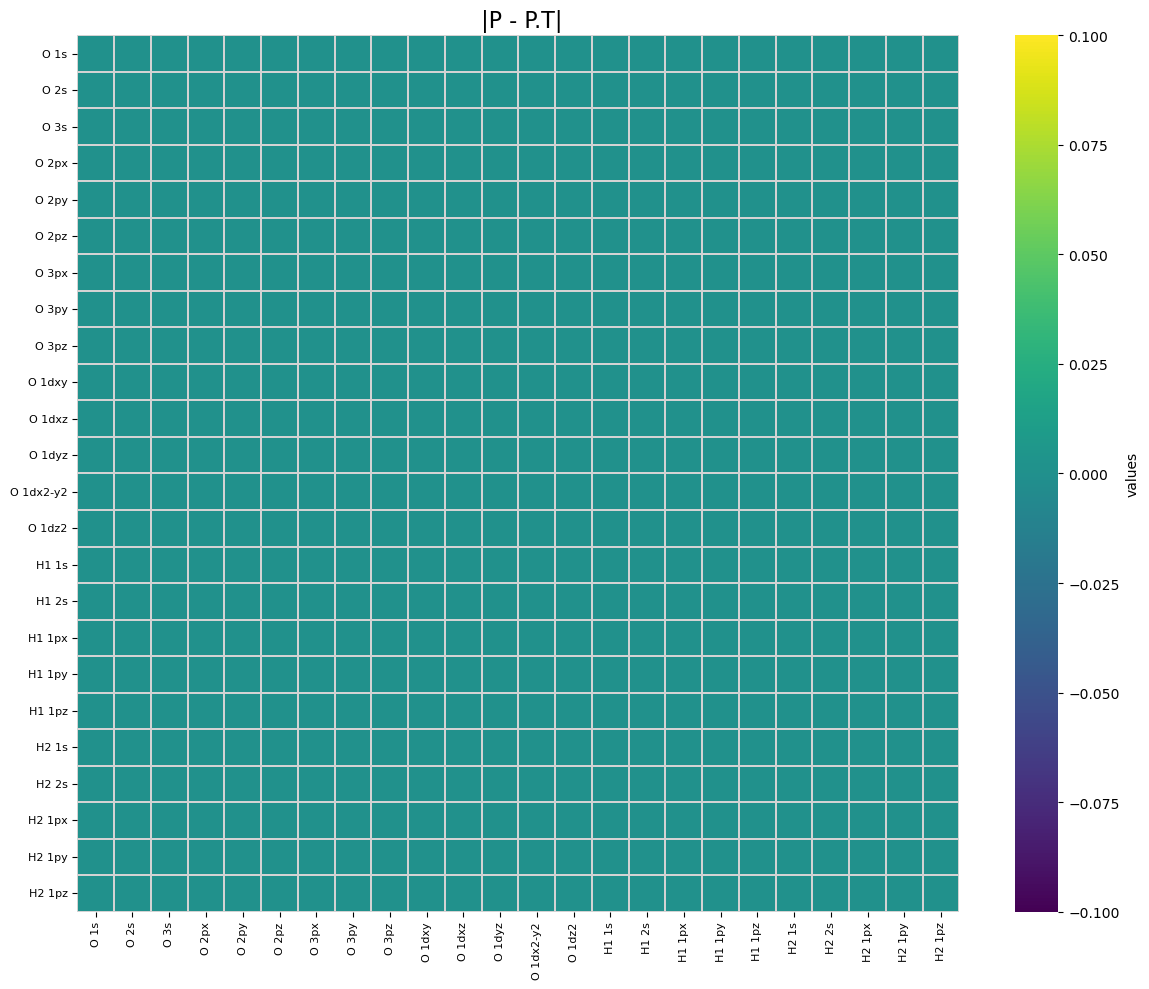

In [7]:

data = np.mean(symme, 0)

o_bfs = [
    'O 1s', 'O 2s', 'O 3s',                 # 3 s-type functions
    'O 2px', 'O 2py', 'O 2pz',              # 1st set of p-type functions (2p)
    'O 3px', 'O 3py', 'O 3pz',              # 2nd set of p-type functions (3p - polarization)
    'O 1dxy', 'O 1dxz', 'O 1dyz', 'O 1dx2-y2', 'O 1dz2' # 1 set of d-type functions (1d - polarization)
]

# Basis functions for Hydrogen (H) in cc-pVDZ (5 functions)
# H is 2s, 1p
h_bfs_template = [ # Using a template for H to easily differentiate H1 and H2
    '1s', '2s',
    '1px', '1py', '1pz'
]

# Construct combined labels for H2O in O, H1, H2 order
all_labels_h2o = o_bfs + \
                 [f'H1 {bf}' for bf in h_bfs_template] + \
                 [f'H2 {bf}' for bf in h_bfs_template]
# --- Create Pandas DataFrame for better labeling in Seaborn ---
# Using data as the actual matrix from your calculation
data_df = pd.DataFrame(data, index=all_labels, columns=all_labels)

# --- Create the Heatmap using Seaborn ---

# Set a larger figure size for better visibility
plt.figure(figsize=(12, 10)) # Increased size for 29x29 matrix and labels

sns.heatmap(data_df,
            annot=False,      # Set to True to show values (might be too crowded for 29x29)
            cmap='viridis',   # Color map (e.g., 'viridis', 'plasma', 'coolwarm', 'RdBu')
            linewidths=.2,    # Lines between cells for separation
            linecolor='lightgray', # Color of the lines
            cbar=True,        # Show color bar
            cbar_kws={'label': 'values'} # Specific label for the color bar
           )

# Add titles and labels for clarity
plt.title(' |P - P.T|', fontsize=16)
# Labels are handled by the DataFrame index/columns by default.
# If you want to explicitly add general labels for axes:
# plt.xlabel('Basis Function Index', fontsize=12)
# plt.ylabel('Basis Function Index', fontsize=12)

# Rotate x-axis labels for better readability if they overlap
plt.xticks(rotation=90, fontsize=8) # Rotate by 90 degrees for vertical labels
plt.yticks(rotation=0, fontsize=8)  # Keep y-axis labels horizontal

# Ensure the layout is tight to prevent labels from overlapping
plt.tight_layout()


# --- NEW LINE TO SAVE THE PLOT ---
plt.savefig('symm_diff_hm.png', dpi=300, bbox_inches='tight')
# Display the plot
plt.show()

/var/folders/8d/k0f53h611hn08ljltzmmh8br0000gn/T/ipykernel_20886/3073310062.py:57: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


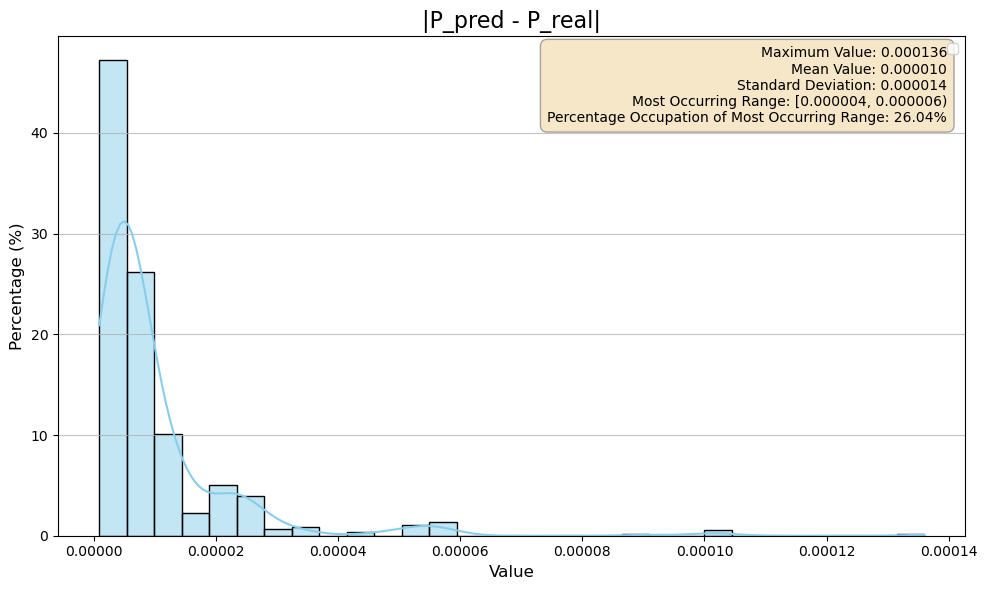

In [8]:
"""
######################################################################
################ HISTOGRAMS #############################################
######################################################################
"""



flat_data = np.mean(dm_diff, 0).flatten()

# --- 2. Calculate Key Statistics ---
max_value = np.max(flat_data)
mean_value = np.mean(flat_data)
std_dev = np.std(flat_data)

# --- 3. Determine the Most Occurring Range and its Percentage Occupation ---
# We'll calculate the histogram counts and bin edges
counts, bin_edges = np.histogram(flat_data, bins='auto')

# Find the bin with the maximum count
most_occurring_bin_idx = np.argmax(counts)
most_occurring_count = counts[most_occurring_bin_idx]

# Get the range of this most occurring bin
most_occurring_range_start = bin_edges[most_occurring_bin_idx]
most_occurring_range_end = bin_edges[most_occurring_bin_idx + 1]

# Calculate its percentage of total data points
total_data_points = len(flat_data)
percentage_occupation = (most_occurring_count / total_data_points) * 100

# --- 4. Prepare Statistics for Display on Plot ---
stats_text = (
    f"Maximum Value: {max_value:.6f}\n"
    f"Mean Value: {mean_value:.6f}\n"
    f"Standard Deviation: {std_dev:.6f}\n"
    f"Most Occurring Range: [{most_occurring_range_start:.6f}, {most_occurring_range_end:.6f})\n"
    f"Percentage Occupation of Most Occurring Range: {percentage_occupation:.2f}%"
)

# --- 5. Create the Histogram Plot ---

plt.figure(figsize=(10, 6))

# Use Seaborn's histplot with 'stat="percent"' for y-axis as percentages
# 'stat="percent"' scales the counts so that the sum of the bar heights equals 100.
# 'kde=True' still works, providing a density curve.
sns.histplot(flat_data, bins=30, kde=True, stat='percent', color='skyblue', edgecolor='black')

# Add vertical lines for key statistics
#plt.axvline(mean_value, color='red', linestyle='--', linewidth=1.5, label=f'Mean: {mean_value:.6f}')
#plt.axvline(max_value, color='purple', linestyle=':', linewidth=1.5, label=f'Max: {max_value:.6f}')

plt.title('|P_pred - P_real|', fontsize=16)
plt.xlabel('Value', fontsize=12)
plt.ylabel('Percentage (%)', fontsize=12) # Changed Y-axis label to Percentage
plt.legend()
plt.grid(axis='y', alpha=0.75)

# --- Add Statistics Text Inside the Plot ---
# We'll place the text in the top-right corner.
# 'transform=plt.gca().transAxes' makes coordinates relative to the axes (0,0 bottom-left, 1,1 top-right)
plt.text(0.98, 0.98, stats_text,
         transform=plt.gca().transAxes,
         fontsize=10,
         verticalalignment='top',    # Align text to the top of the given y-coordinate
         horizontalalignment='right', # Align text to the right of the given x-coordinate
         bbox=dict(boxstyle='round,pad=0.5', fc='wheat', alpha=0.7, ec='gray', lw=1) # Add a background box
        )

plt.tight_layout()

# Save the histogram as a PNG image
plt.savefig('dm_diff_hist.png', dpi=300, bbox_inches='tight')

plt.show()

/var/folders/8d/k0f53h611hn08ljltzmmh8br0000gn/T/ipykernel_20886/647494577.py:49: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


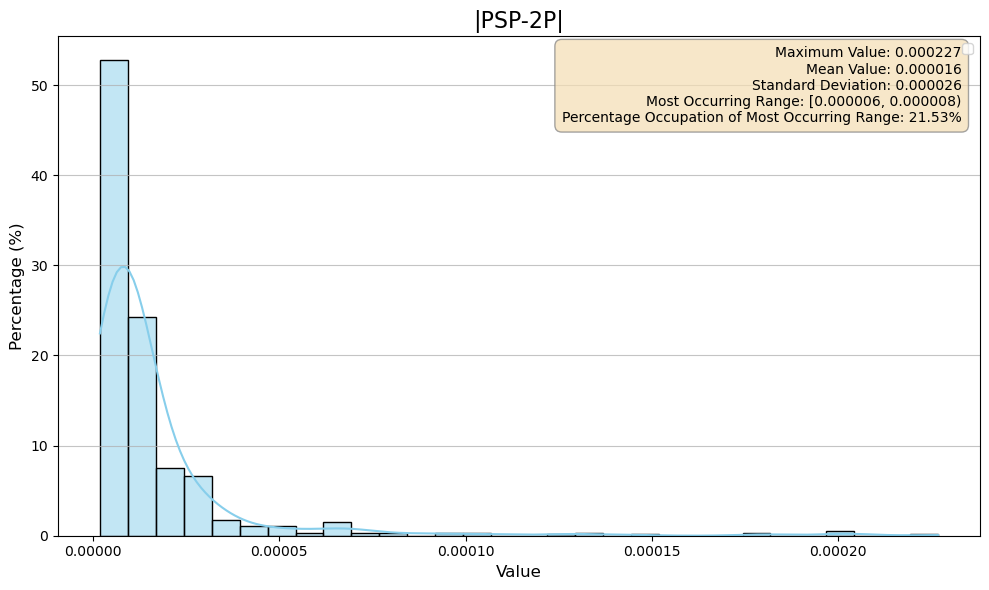

In [9]:
flat_data = np.mean(id_err, 0).flatten()

# --- 2. Calculate Key Statistics ---
max_value = np.max(flat_data)
mean_value = np.mean(flat_data)
std_dev = np.std(flat_data)

# --- 3. Determine the Most Occurring Range and its Percentage Occupation ---
# We'll calculate the histogram counts and bin edges
counts, bin_edges = np.histogram(flat_data, bins='auto')

# Find the bin with the maximum count
most_occurring_bin_idx = np.argmax(counts)
most_occurring_count = counts[most_occurring_bin_idx]

# Get the range of this most occurring bin
most_occurring_range_start = bin_edges[most_occurring_bin_idx]
most_occurring_range_end = bin_edges[most_occurring_bin_idx + 1]

# Calculate its percentage of total data points
total_data_points = len(flat_data)
percentage_occupation = (most_occurring_count / total_data_points) * 100

# --- 4. Prepare Statistics for Display on Plot ---
stats_text = (
    f"Maximum Value: {max_value:.6f}\n"
    f"Mean Value: {mean_value:.6f}\n"
    f"Standard Deviation: {std_dev:.6f}\n"
    f"Most Occurring Range: [{most_occurring_range_start:.6f}, {most_occurring_range_end:.6f})\n"
    f"Percentage Occupation of Most Occurring Range: {percentage_occupation:.2f}%"
)

# --- 5. Create the Histogram Plot ---

plt.figure(figsize=(10, 6))

# Use Seaborn's histplot with 'stat="percent"' for y-axis as percentages
# 'stat="percent"' scales the counts so that the sum of the bar heights equals 100.
# 'kde=True' still works, providing a density curve.
sns.histplot(flat_data, bins=30, kde=True, stat='percent', color='skyblue', edgecolor='black')

# Add vertical lines for key statistics
#plt.axvline(mean_value, color='red', linestyle='--', linewidth=1.5, label=f'Mean: {mean_value:.6f}')
#plt.axvline(max_value, color='purple', linestyle=':', linewidth=1.5, label=f'Max: {max_value:.6f}')

plt.title('|PSP-2P|', fontsize=16)
plt.xlabel('Value', fontsize=12)
plt.ylabel('Percentage (%)', fontsize=12) # Changed Y-axis label to Percentage
plt.legend()
plt.grid(axis='y', alpha=0.75)

# --- Add Statistics Text Inside the Plot ---
# We'll place the text in the top-right corner.
# 'transform=plt.gca().transAxes' makes coordinates relative to the axes (0,0 bottom-left, 1,1 top-right)
plt.text(0.98, 0.98, stats_text,
         transform=plt.gca().transAxes,
         fontsize=10,
         verticalalignment='top',    # Align text to the top of the given y-coordinate
         horizontalalignment='right', # Align text to the right of the given x-coordinate
         bbox=dict(boxstyle='round,pad=0.5', fc='wheat', alpha=0.7, ec='gray', lw=1) # Add a background box
        )

plt.tight_layout()

# Save the histogram as a PNG image
plt.savefig('Szabo_diff_hist.png', dpi=300, bbox_inches='tight')

plt.show()

/var/folders/8d/k0f53h611hn08ljltzmmh8br0000gn/T/ipykernel_20886/4221019299.py:49: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


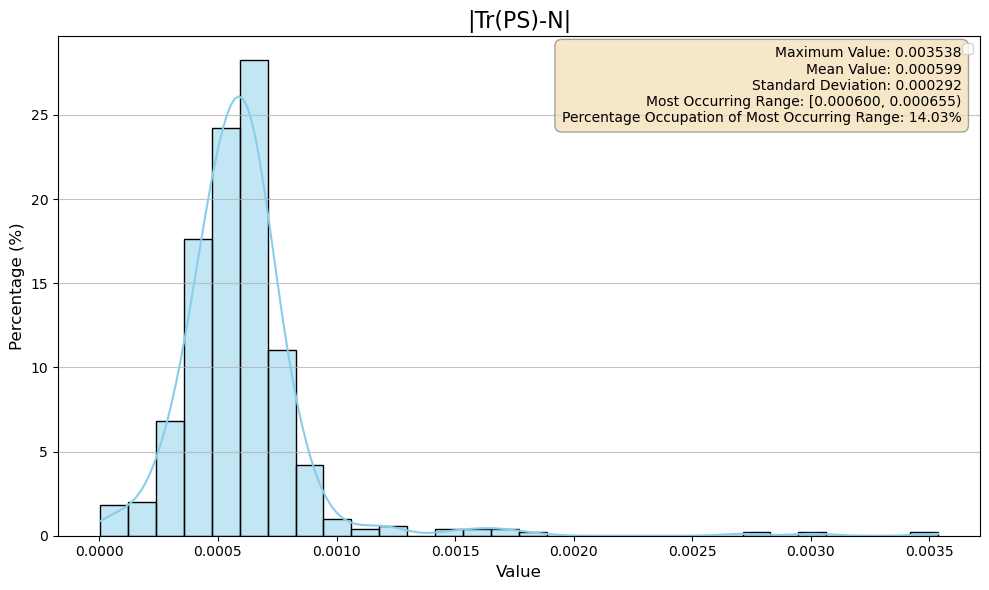

In [10]:
flat_data = tr_err

# --- 2. Calculate Key Statistics ---
max_value = np.max(flat_data)
mean_value = np.mean(flat_data)
std_dev = np.std(flat_data)

# --- 3. Determine the Most Occurring Range and its Percentage Occupation ---
# We'll calculate the histogram counts and bin edges
counts, bin_edges = np.histogram(flat_data, bins='auto')

# Find the bin with the maximum count
most_occurring_bin_idx = np.argmax(counts)
most_occurring_count = counts[most_occurring_bin_idx]

# Get the range of this most occurring bin
most_occurring_range_start = bin_edges[most_occurring_bin_idx]
most_occurring_range_end = bin_edges[most_occurring_bin_idx + 1]

# Calculate its percentage of total data points
total_data_points = len(flat_data)
percentage_occupation = (most_occurring_count / total_data_points) * 100

# --- 4. Prepare Statistics for Display on Plot ---
stats_text = (
    f"Maximum Value: {max_value:.6f}\n"
    f"Mean Value: {mean_value:.6f}\n"
    f"Standard Deviation: {std_dev:.6f}\n"
    f"Most Occurring Range: [{most_occurring_range_start:.6f}, {most_occurring_range_end:.6f})\n"
    f"Percentage Occupation of Most Occurring Range: {percentage_occupation:.2f}%"
)

# --- 5. Create the Histogram Plot ---

plt.figure(figsize=(10, 6))

# Use Seaborn's histplot with 'stat="percent"' for y-axis as percentages
# 'stat="percent"' scales the counts so that the sum of the bar heights equals 100.
# 'kde=True' still works, providing a density curve.
sns.histplot(flat_data, bins=30, kde=True, stat='percent', color='skyblue', edgecolor='black')

# Add vertical lines for key statistics
#plt.axvline(mean_value, color='red', linestyle='--', linewidth=1.5, label=f'Mean: {mean_value:.6f}')
#plt.axvline(max_value, color='purple', linestyle=':', linewidth=1.5, label=f'Max: {max_value:.6f}')

plt.title('|Tr(PS)-N|', fontsize=16)
plt.xlabel('Value', fontsize=12)
plt.ylabel('Percentage (%)', fontsize=12) # Changed Y-axis label to Percentage
plt.legend()
plt.grid(axis='y', alpha=0.75)

# --- Add Statistics Text Inside the Plot ---
# We'll place the text in the top-right corner.
# 'transform=plt.gca().transAxes' makes coordinates relative to the axes (0,0 bottom-left, 1,1 top-right)
plt.text(0.98, 0.98, stats_text,
         transform=plt.gca().transAxes,
         fontsize=10,
         verticalalignment='top',    # Align text to the top of the given y-coordinate
         horizontalalignment='right', # Align text to the right of the given x-coordinate
         bbox=dict(boxstyle='round,pad=0.5', fc='wheat', alpha=0.7, ec='gray', lw=1) # Add a background box
        )

plt.tight_layout()

# Save the histogram as a PNG image
plt.savefig('trace_diff_hist.png', dpi=300, bbox_inches='tight')

plt.show()

/var/folders/8d/k0f53h611hn08ljltzmmh8br0000gn/T/ipykernel_20886/1591164410.py:49: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


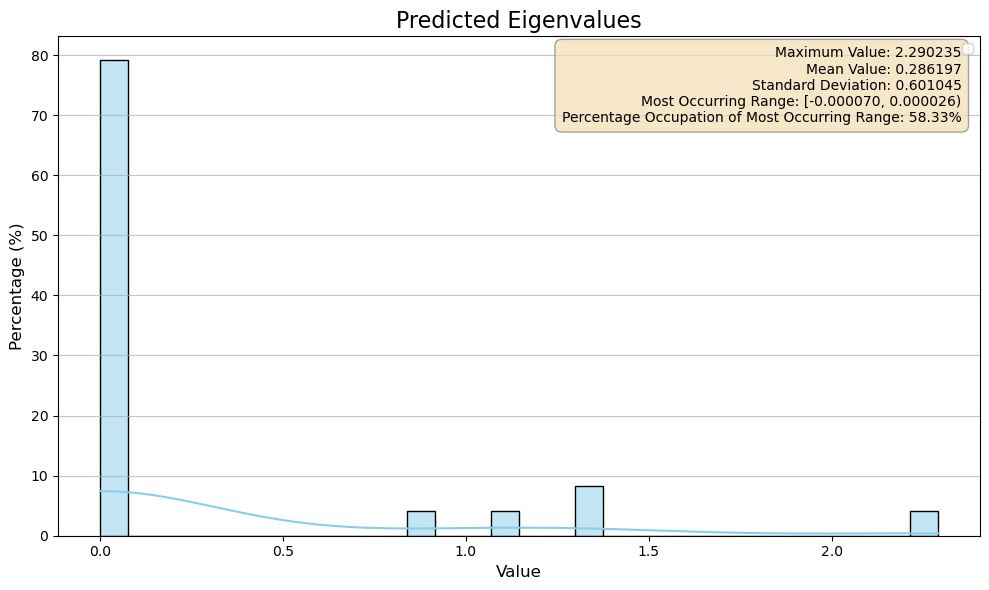

In [11]:
flat_data = np.mean(dm_eigvals_pred, 0).flatten()

# --- 2. Calculate Key Statistics ---
max_value = np.max(flat_data)
mean_value = np.mean(flat_data)
std_dev = np.std(flat_data)

# --- 3. Determine the Most Occurring Range and its Percentage Occupation ---
# We'll calculate the histogram counts and bin edges
counts, bin_edges = np.histogram(flat_data, bins='auto')

# Find the bin with the maximum count
most_occurring_bin_idx = np.argmax(counts)
most_occurring_count = counts[most_occurring_bin_idx]

# Get the range of this most occurring bin
most_occurring_range_start = bin_edges[most_occurring_bin_idx]
most_occurring_range_end = bin_edges[most_occurring_bin_idx + 1]

# Calculate its percentage of total data points
total_data_points = len(flat_data)
percentage_occupation = (most_occurring_count / total_data_points) * 100

# --- 4. Prepare Statistics for Display on Plot ---
stats_text = (
    f"Maximum Value: {max_value:.6f}\n"
    f"Mean Value: {mean_value:.6f}\n"
    f"Standard Deviation: {std_dev:.6f}\n"
    f"Most Occurring Range: [{most_occurring_range_start:.6f}, {most_occurring_range_end:.6f})\n"
    f"Percentage Occupation of Most Occurring Range: {percentage_occupation:.2f}%"
)

# --- 5. Create the Histogram Plot ---

plt.figure(figsize=(10, 6))

# Use Seaborn's histplot with 'stat="percent"' for y-axis as percentages
# 'stat="percent"' scales the counts so that the sum of the bar heights equals 100.
# 'kde=True' still works, providing a density curve.
sns.histplot(flat_data, bins=30, kde=True, stat='percent', color='skyblue', edgecolor='black')

# Add vertical lines for key statistics
#plt.axvline(mean_value, color='red', linestyle='--', linewidth=1.5, label=f'Mean: {mean_value:.6f}')
#plt.axvline(max_value, color='purple', linestyle=':', linewidth=1.5, label=f'Max: {max_value:.6f}')

plt.title('Predicted Eigenvalues', fontsize=16)
plt.xlabel('Value', fontsize=12)
plt.ylabel('Percentage (%)', fontsize=12) # Changed Y-axis label to Percentage
plt.legend()
plt.grid(axis='y', alpha=0.75)

# --- Add Statistics Text Inside the Plot ---
# We'll place the text in the top-right corner.
# 'transform=plt.gca().transAxes' makes coordinates relative to the axes (0,0 bottom-left, 1,1 top-right)
plt.text(0.98, 0.98, stats_text,
         transform=plt.gca().transAxes,
         fontsize=10,
         verticalalignment='top',    # Align text to the top of the given y-coordinate
         horizontalalignment='right', # Align text to the right of the given x-coordinate
         bbox=dict(boxstyle='round,pad=0.5', fc='wheat', alpha=0.7, ec='gray', lw=1) # Add a background box
        )

plt.tight_layout()

# Save the histogram as a PNG image
plt.savefig('pred_eigval_hist.png', dpi=300, bbox_inches='tight')

plt.show()

/var/folders/8d/k0f53h611hn08ljltzmmh8br0000gn/T/ipykernel_20886/821398326.py:49: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


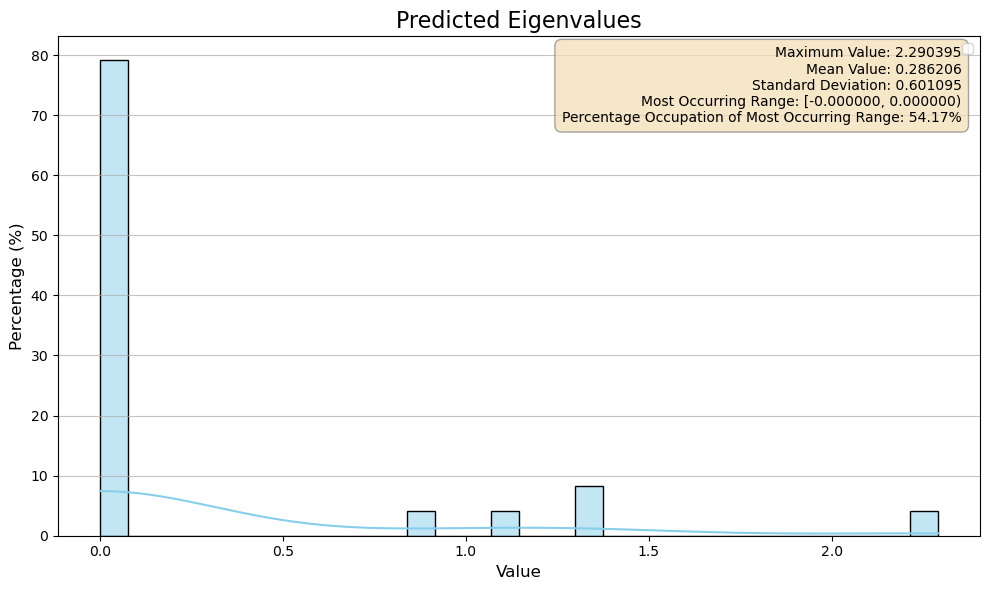

In [12]:
flat_data = np.mean(dm_eigvals_real, 0).flatten()

# --- 2. Calculate Key Statistics ---
max_value = np.max(flat_data)
mean_value = np.mean(flat_data)
std_dev = np.std(flat_data)

# --- 3. Determine the Most Occurring Range and its Percentage Occupation ---
# We'll calculate the histogram counts and bin edges
counts, bin_edges = np.histogram(flat_data, bins='auto')

# Find the bin with the maximum count
most_occurring_bin_idx = np.argmax(counts)
most_occurring_count = counts[most_occurring_bin_idx]

# Get the range of this most occurring bin
most_occurring_range_start = bin_edges[most_occurring_bin_idx]
most_occurring_range_end = bin_edges[most_occurring_bin_idx + 1]

# Calculate its percentage of total data points
total_data_points = len(flat_data)
percentage_occupation = (most_occurring_count / total_data_points) * 100

# --- 4. Prepare Statistics for Display on Plot ---
stats_text = (
    f"Maximum Value: {max_value:.6f}\n"
    f"Mean Value: {mean_value:.6f}\n"
    f"Standard Deviation: {std_dev:.6f}\n"
    f"Most Occurring Range: [{most_occurring_range_start:.6f}, {most_occurring_range_end:.6f})\n"
    f"Percentage Occupation of Most Occurring Range: {percentage_occupation:.2f}%"
)

# --- 5. Create the Histogram Plot ---

plt.figure(figsize=(10, 6))

# Use Seaborn's histplot with 'stat="percent"' for y-axis as percentages
# 'stat="percent"' scales the counts so that the sum of the bar heights equals 100.
# 'kde=True' still works, providing a density curve.
sns.histplot(flat_data, bins=30, kde=True, stat='percent', color='skyblue', edgecolor='black')

# Add vertical lines for key statistics
#plt.axvline(mean_value, color='red', linestyle='--', linewidth=1.5, label=f'Mean: {mean_value:.6f}')
#plt.axvline(max_value, color='purple', linestyle=':', linewidth=1.5, label=f'Max: {max_value:.6f}')

plt.title('Predicted Eigenvalues', fontsize=16)
plt.xlabel('Value', fontsize=12)
plt.ylabel('Percentage (%)', fontsize=12) # Changed Y-axis label to Percentage
plt.legend()
plt.grid(axis='y', alpha=0.75)

# --- Add Statistics Text Inside the Plot ---
# We'll place the text in the top-right corner.
# 'transform=plt.gca().transAxes' makes coordinates relative to the axes (0,0 bottom-left, 1,1 top-right)
plt.text(0.98, 0.98, stats_text,
         transform=plt.gca().transAxes,
         fontsize=10,
         verticalalignment='top',    # Align text to the top of the given y-coordinate
         horizontalalignment='right', # Align text to the right of the given x-coordinate
         bbox=dict(boxstyle='round,pad=0.5', fc='wheat', alpha=0.7, ec='gray', lw=1) # Add a background box
        )

plt.tight_layout()

# Save the histogram as a PNG image
plt.savefig('real_eigval_hist.png', dpi=300, bbox_inches='tight')

plt.show()

In [13]:
pyscf_preds = transform(dms_pred, convention = "phipy")
pyscf_real = transform(dms_real, convention = "phipy")

np.mean(np.abs(pyscf_preds-pyscf_real))

index = 10

r = rs[index]
dm_real = pyscf_real[index]
dm_pred = pyscf_preds[index]

In [29]:
mol = create_pyscf_molecule(r)  # assumes r is in Bohr

# Setup DFT object
mf = dft.RKS(mol)
mf.xc = 'PBE'
mf.grids.level = 5
mf.conv_tol = 1e-11
mf.conv_tol_grad = 1e-6                # Tight gradient convergence (Hartree/Bohr)
mf.conv_tol_density = 1e-8
mf.grids.atom_grid = (99, 590)
mf.grids.prune = False
mf.max_cycle = 180
mf.verbose = 0
counter = {'n': 0}
def count_iterations(envs): counter['n'] += 1
mf.callback = count_iterations


mf.kernel(dm0=dm_pred)
dm1   = mf.make_rdm1()   
s1 = mf.get_ovlp() 
       


print(counter["n"])



5


In [30]:
# Function to run SCF with given initial density matrix or method
def run_scf_with_guess(mol, guess=None, dm0=None):
    mf = dft.RKS(mol)
    mf.xc = 'PBE'
    mf.grids.level = 5
    mf.conv_tol = 1e-11
    mf.conv_tol_grad = 1e-6                # Tight gradient convergence (Hartree/Bohr)
    mf.conv_tol_density = 1e-8
    mf.grids.prune = False
    mf.max_cycle = 180
    mf.grids.atom_grid = (99, 590)
    mf.verbose = 0
    counter = {'n': 0}
    
    def count_iterations(envs):
        counter['n'] += 1

    mf.callback = count_iterations

    if dm0 is not None:
        mf.kernel(dm0=dm0)
    elif guess is not None:
        mol.set_common_orig((0,0,0))  # For atom guess stability
        mf.init_guess = guess
        mf.kernel()
    else:
        mf.kernel()

    return counter['n']

# Build molecule
mol = create_pyscf_molecule(r)

# Dictionary to store iteration results
results = {}

# Standard PySCF guesses
guesses = ['1e', 'minao', 'atom', 'huckel']
for guess in guesses:
    results[guess] = run_scf_with_guess(mol, guess=guess)

# Your predicted DM (must match mol.nao × mol.nao)
results['pred'] = run_scf_with_guess(mol, dm0=dm1)

# Display results
print("\nSCF Iteration Counts:")
for k, v in results.items():
    print(f"{k:>6}: {v} iterations")


SCF Iteration Counts:
    1e: 12 iterations
 minao: 9 iterations
  atom: 9 iterations
huckel: 9 iterations
  pred: 1 iterations
